In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

데이터셋

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [ ]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
    
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                  "image": _input,
                  "mask": _output,
                    }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## U-Net

모델 준비 및 학습

In [6]:
def build_model(input_shape=(224, 224, 3), num_classes=1):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.

    # 인코더
    # 1
    input_layer = tf.keras.layers.Input(shape=input_shape) 
    x = input_layer
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    enc1 = x
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # 2
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    enc2 = x
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # 3
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    enc3 = x
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # 4
    x = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    enc4 = x
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    # 5
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(1024, (3, 3), padding="same", activation="relu")(x)

    # 디코더
    # 4
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.concatenate([x,enc4])
    x = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    # 3
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.concatenate([x,enc3])
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    # 2
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.concatenate([x,enc2])
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    # 1
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.concatenate([x,enc1])
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    outputs = tf.keras.layers.Conv2D(num_classes, (1,1), padding="same", activation="sigmoid")(x)

    model = tf.keras.Model(inputs=input_layer, outputs=outputs)

    return model

In [7]:
class lrHistory(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lr = []
        
    def on_epoch_begin(self, epoch, logs):
        self.lr.append(float(tf.keras.backend.get_value(self.model.optimizer.lr)))

In [8]:
def dice_coef(y_true, y_pred, smooth=1e-6):   # F1-score와 동일
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    dice = (2.0 * intersection + smooth) / (union + smooth)  # 수치 안정성과 0으로 나누기 방지를 위해 smooth를 분모, 분자에 모두 더해줌
    return dice

intersection = np.logical_and(y_true, y_pred)
union = np.logical_or(y_true, y_pred)

원래는 위와 같이 구현했었는데 TensorFlow에서 모델 학습 중에는 tf나 K만 써야 하고 np는 사용할 수 없다고 함

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

lr_history = lrHistory()
model = build_model()
model.summary()

In [14]:
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=[dice_coef])
history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[lr_history]
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 39s 2s/step - loss: 0.6473 - dice_coef: 0.0114 - val_loss: 0.6080 - val_dice_coef: 5.4209e-12
Epoch 2/100
11/11 [==============================] - 11s 928ms/step - loss: 0.5435 - dice_coef: 6.4222e-12 - val_loss: 0.5215 - val_dice_coef: 5.4209e-12
Epoch 3/100
11/11 [==============================] - 11s 944ms/step - loss: 0.4023 - dice_coef: 6.0611e-12 - val_loss: 0.3340 - val_dice_coef: 5.4209e-12
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 0.3286 - dice_coef: 6.1415e-12 - val_loss: 0.3651 - val_dice_coef: 5.4209e-12
Epoch 5/100
11/11 [==============================] - 11s 956ms/step - loss: 0.2920 - dice_coef: 6.5393e-12 - val_loss: 0.2943 - val_dice_coef: 5.1879e-06
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.3377 - dice_coef: 0.3357 - val_loss: 0.3955 - val_dice_coef: 0.3546
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.2864 - dice_coef: 0.65

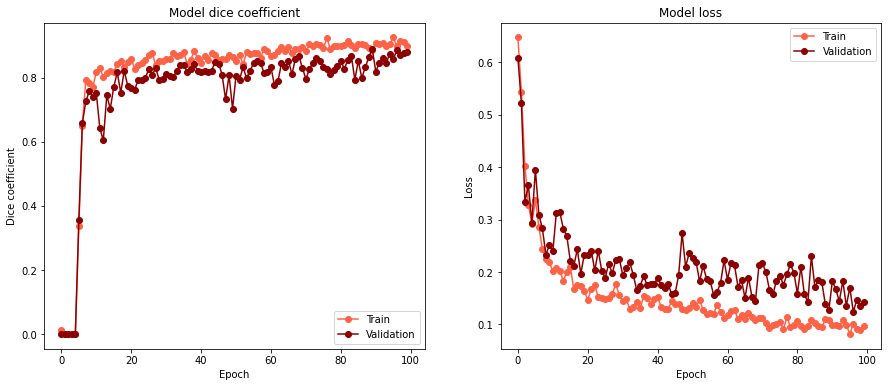

In [26]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(history.history['dice_coef'], color='tomato', marker='o', linestyle='solid')
plt.plot(history.history['val_dice_coef'], color='darkred', marker='o', linestyle='solid')
plt.title('Model dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='tomato', marker='o', linestyle='solid')
plt.plot(history.history['val_loss'], color='darkred', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

시각화

In [42]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path, custom_objects={"dice_coef": dice_coef})

In [9]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print('IoU : %f' % iou_score )
    return iou_score

In [10]:
def get_output(model, preproc, image_path, output_path, label_path, threshold=0.5):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=threshold).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
iou = 0.0
for i in range(10):
    output, prediction, target = get_output(
        model, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
        threshold=0.5
     )
    
    iou += calculate_iou_score(target, prediction)
iou /= 10
print("===========================")
print(f"avg iou : {iou}")

avg iou : 0.8216555334208838

깃허브에서 해당 파일의 용량이 너무 커서 display할 수 없다고 하여 segmentation 결과 이미지를 삭제하고 최종 IoU값만 적어놓았습니다.<br>
Copy본이 아닌 원본에는 결과 이미지가 있습니다.

---

## U-Net++

In [11]:
def conv(inputs, filters):
    x = inputs
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    return x

def skip_conn(x, u, filters):
    u = tf.keras.layers.UpSampling2D((2, 2))(u) # 업샘플링한 블록
    c = x[0]
    
    for i in x[1:]:
        c = tf.keras.layers.concatenate([c,i])
        
    c = conv(c, filters)
    h = tf.keras.layers.concatenate([c,u])
    return h

def build_model_plus(input_shape=(224, 224, 3), num_classes=1):
    model = None
    x = [[None for col in range(5)] for row in range(5)]
    filters = [64, 128, 256, 512, 1024]

    input_layer = tf.keras.layers.Input(shape=input_shape) 
    x[0][0] = conv(input_layer, filters[0])

    for i in range(1,5):
        mp = tf.keras.layers.MaxPooling2D((2, 2))(x[i-1][0])
        x[i][0] = conv(mp, filters[i])
        for j in range(1,i+1):
            x[i-j][j] = skip_conn(x[i-j][:j], x[i-j+1][j-1], filters[i-j])

    outputs = tf.keras.layers.Conv2D(num_classes, (1,1), padding="same", activation="sigmoid")(x[0][4])
    
    model = tf.keras.Model(inputs=input_layer, outputs=outputs)

    return model

In [29]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    batch_size=2,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=2,
    augmentation=test_preproc,
    is_train=False
)

ResourceExhaustedError가 발생해서 batch_size 2로 설정

In [ ]:
model_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

lr_history_plus = lrHistory()
model_plus = build_model_plus()
model_plus.summary()

In [30]:
model_plus.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=[dice_coef])
history_plus = model_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[lr_history_plus]
 )

model_plus.save(model_plus_path)

Epoch 1/100
85/85 [==============================] - 75s 677ms/step - loss: 0.4002 - dice_coef: 0.4450 - val_loss: 0.2656 - val_dice_coef: 0.8177
Epoch 2/100
85/85 [==============================] - 46s 534ms/step - loss: 0.2600 - dice_coef: 0.7451 - val_loss: 0.2694 - val_dice_coef: 0.7394
Epoch 3/100
85/85 [==============================] - 46s 541ms/step - loss: 0.2157 - dice_coef: 0.7787 - val_loss: 0.2409 - val_dice_coef: 0.8040
Epoch 4/100
85/85 [==============================] - 46s 540ms/step - loss: 0.1915 - dice_coef: 0.8047 - val_loss: 0.2687 - val_dice_coef: 0.7401
Epoch 5/100
85/85 [==============================] - 46s 540ms/step - loss: 0.2109 - dice_coef: 0.7830 - val_loss: 0.3294 - val_dice_coef: 0.7121
Epoch 6/100
85/85 [==============================] - 46s 539ms/step - loss: 0.1856 - dice_coef: 0.7994 - val_loss: 0.2366 - val_dice_coef: 0.7836
Epoch 7/100
85/85 [==============================] - 46s 540ms/step - loss: 0.1919 - dice_coef: 0.8000 - val_loss: 0.2460 - 

85/85 [==============================] - 46s 535ms/step - loss: 0.1042 - dice_coef: 0.8736 - val_loss: 0.1965 - val_dice_coef: 0.8155
Epoch 56/100
85/85 [==============================] - 45s 535ms/step - loss: 0.1019 - dice_coef: 0.8824 - val_loss: 0.1748 - val_dice_coef: 0.8292
Epoch 57/100
85/85 [==============================] - 46s 534ms/step - loss: 0.1094 - dice_coef: 0.8744 - val_loss: 0.1564 - val_dice_coef: 0.8704
Epoch 58/100
85/85 [==============================] - 45s 532ms/step - loss: 0.1041 - dice_coef: 0.9024 - val_loss: 0.1859 - val_dice_coef: 0.8350
Epoch 59/100
85/85 [==============================] - 45s 534ms/step - loss: 0.1052 - dice_coef: 0.8641 - val_loss: 0.1932 - val_dice_coef: 0.8312
Epoch 60/100
85/85 [==============================] - 45s 532ms/step - loss: 0.0970 - dice_coef: 0.8689 - val_loss: 0.2284 - val_dice_coef: 0.8010
Epoch 61/100
85/85 [==============================] - 46s 534ms/step - loss: 0.1014 - dice_coef: 0.8673 - val_loss: 0.1891 - val_di

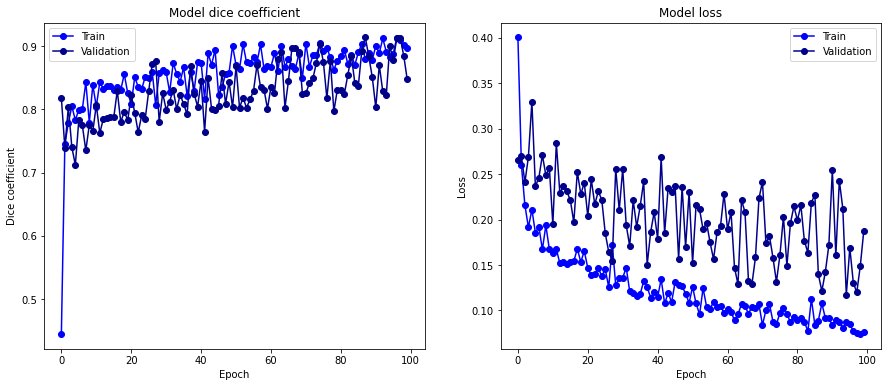

In [31]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(history_plus.history['dice_coef'], color='blue', marker='o', linestyle='solid')
plt.plot(history_plus.history['val_dice_coef'], color='darkblue', marker='o', linestyle='solid')
plt.title('Model dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history_plus.history['loss'], color='blue', marker='o', linestyle='solid')
plt.plot(history_plus.history['val_loss'], color='darkblue', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

Train에 비해 Validation의 dice coefficient와 loss의 진동이 심함 

In [12]:
model_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'
model_plus = tf.keras.models.load_model(model_plus_path, custom_objects={"dice_coef": dice_coef})

In [ ]:
iou = 0.0
for i in range(10):
    output, prediction, target = get_output(
        model_plus, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
        threshold=0.5
     )
    
    iou += calculate_iou_score(target, prediction)
iou /= 10
print("===========================")
print(f"avg iou : {iou}")

avg iou : 0.8369839564815991

Deep supervision 부분을 구현하지 않았고, 마지막 feature map인 x[0][4]만 사용한 모델.<br>
U-Net보다 약 1% 성능이 좋아짐.

## U-Net++ (Deep supervision 적용)

In [33]:
def build_model_plus2(input_shape=(224, 224, 3), num_classes=1):
    model = None
    x = [[None for col in range(5)] for row in range(5)]
    filters = [64, 128, 256, 512, 1024]

    input_layer = tf.keras.layers.Input(shape=input_shape) 
    x[0][0] = conv(input_layer, filters[0])

    for i in range(1,5):
        mp = tf.keras.layers.MaxPooling2D((2, 2))(x[i-1][0])
        x[i][0] = conv(mp, filters[i])
        for j in range(1,i+1):
            x[i-j][j] = skip_conn(x[i-j][:j], x[i-j+1][j-1], filters[i-j])

    deep_sup = []
    for j in range(1,5):
        output = tf.keras.layers.Conv2D(num_classes, (1,1), padding="same", activation="sigmoid")(x[0][j])
        deep_sup.append(output)
        
    outputs = tf.keras.layers.Average()(deep_sup)
    
    model = tf.keras.Model(inputs=input_layer, outputs=outputs)

    return model

In [ ]:
model_plus_path2 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus2.h5'

lr_history_plus2 = lrHistory()
model_plus2 = build_model_plus2()
model_plus2.summary()

In [35]:
model_plus2.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=[dice_coef])
history_plus2 = model_plus2.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[lr_history_plus2]
 )

model_plus2.save(model_plus_path2)

Epoch 1/100
85/85 [==============================] - 52s 578ms/step - loss: 0.5100 - dice_coef: 0.0543 - val_loss: 0.3970 - val_dice_coef: 0.3575
Epoch 2/100
85/85 [==============================] - 48s 559ms/step - loss: 0.3478 - dice_coef: 0.5214 - val_loss: 0.3956 - val_dice_coef: 0.6648
Epoch 3/100
85/85 [==============================] - 48s 563ms/step - loss: 0.3087 - dice_coef: 0.6273 - val_loss: 0.5217 - val_dice_coef: 0.5324
Epoch 4/100
85/85 [==============================] - 48s 559ms/step - loss: 0.3062 - dice_coef: 0.6641 - val_loss: 0.4259 - val_dice_coef: 0.6367
Epoch 5/100
85/85 [==============================] - 48s 561ms/step - loss: 0.2839 - dice_coef: 0.7265 - val_loss: 0.5815 - val_dice_coef: 0.3676
Epoch 6/100
85/85 [==============================] - 47s 558ms/step - loss: 0.2814 - dice_coef: 0.7173 - val_loss: 0.4052 - val_dice_coef: 0.6709
Epoch 7/100
85/85 [==============================] - 48s 558ms/step - loss: 0.2693 - dice_coef: 0.7425 - val_loss: 0.3819 - 

85/85 [==============================] - 48s 561ms/step - loss: 0.1969 - dice_coef: 0.8110 - val_loss: 0.3824 - val_dice_coef: 0.6973
Epoch 56/100
85/85 [==============================] - 48s 559ms/step - loss: 0.1865 - dice_coef: 0.8329 - val_loss: 0.3282 - val_dice_coef: 0.7283
Epoch 57/100
85/85 [==============================] - 48s 561ms/step - loss: 0.1855 - dice_coef: 0.8275 - val_loss: 0.2973 - val_dice_coef: 0.7768
Epoch 58/100
85/85 [==============================] - 48s 560ms/step - loss: 0.1967 - dice_coef: 0.7936 - val_loss: 0.2590 - val_dice_coef: 0.7770
Epoch 59/100
85/85 [==============================] - 48s 561ms/step - loss: 0.1812 - dice_coef: 0.8075 - val_loss: 0.3022 - val_dice_coef: 0.7623
Epoch 60/100
85/85 [==============================] - 48s 560ms/step - loss: 0.1856 - dice_coef: 0.7837 - val_loss: 0.2739 - val_dice_coef: 0.7783
Epoch 61/100
85/85 [==============================] - 48s 561ms/step - loss: 0.1893 - dice_coef: 0.7798 - val_loss: 0.3190 - val_di

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


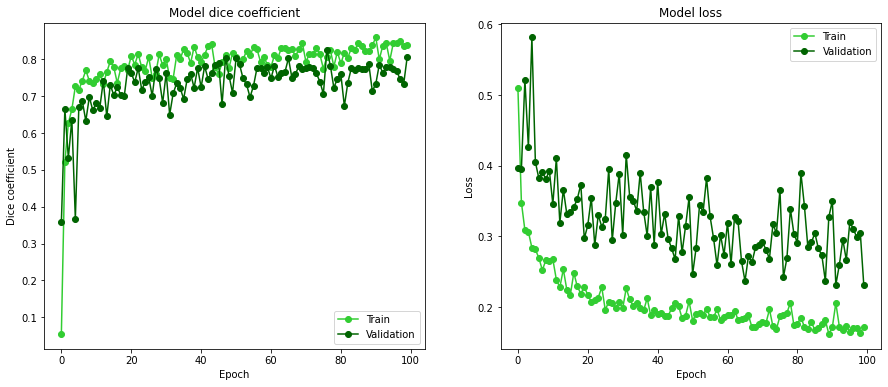

In [36]:
plt.figure(figsize=(15, 6))

plt.subplot(1,2,1)
plt.plot(history_plus2.history['dice_coef'], color='limegreen', marker='o', linestyle='solid')
plt.plot(history_plus2.history['val_dice_coef'], color='darkgreen', marker='o', linestyle='solid')
plt.title('Model dice coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,2,2)
plt.plot(history_plus2.history['loss'], color='limegreen', marker='o', linestyle='solid')
plt.plot(history_plus2.history['val_loss'], color='darkgreen', marker='o', linestyle='solid')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [20]:
model_plus_path2 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus2.h5'
model_plus2 = tf.keras.models.load_model(model_plus_path2, custom_objects={"dice_coef": dice_coef})

In [ ]:
iou = 0.0
for i in range(10):
    output, prediction, target = get_output(
        model_plus2, 
        test_preproc,
        image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
        output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
        label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png',
        threshold=0.5
     )
    
    iou += calculate_iou_score(target, prediction)
iou /= 10
print("===========================")
print(f"avg iou : {iou}")

avg iou : 0.7538222853295514

Gemini 2.5 Pro가 각 output layer를 평균내는 것으로 알려줬는데 논문에는 각 output의 loss 출력값을 평균내는 것이어서 모델을 새로 구현함.<br>
알아보니 deep supervision에 2가지 모드가 있고 아래와 위의 모델 모두 문제는 없는 것 같지만 논문에 정확한 언급이 없어서 위 모델은 맞는지 잘 모르겠음.

In [38]:
def build_model_plus3(input_shape=(224, 224, 3), num_classes=1):
    model = None
    x = [[None for col in range(5)] for row in range(5)]
    filters = [64, 128, 256, 512, 1024]

    input_layer = tf.keras.layers.Input(shape=input_shape) 
    x[0][0] = conv(input_layer, filters[0])

    for i in range(1,5):
        mp = tf.keras.layers.MaxPooling2D((2, 2))(x[i-1][0])
        x[i][0] = conv(mp, filters[i])
        for j in range(1,i+1):
            x[i-j][j] = skip_conn(x[i-j][:j], x[i-j+1][j-1], filters[i-j])

    outputs = []
    for j in range(1,5):
        output = tf.keras.layers.Conv2D(num_classes, (1,1), padding="same", activation="sigmoid")(x[0][j])
        outputs.append(output)
    
    model = tf.keras.Model(inputs=input_layer, outputs=outputs)

    return model

In [39]:
def deep_supervision(y_true, y_preds):
    deep_sup = 0.0
    for y_pred in y_preds:
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        dice = 1 - dice_coef(y_true, y_pred)
        loss = bce + dice
        deep_sup += loss
    final_loss = deep_sup / 4
    return final_loss

model_plus_path3 = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus3.h5'

lr_history_plus3 = lrHistory()
model_plus3 = build_model_plus3()
model_plus3.summary()

In [41]:
model_plus3.compile(optimizer = Adam(1e-4), loss = [deep_supervision], metrics=[dice_coef])
history_plus3 = model_plus3.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[lr_history_plus3]
 )

model_plus3.save(model_plus_path3)

Epoch 1/100


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /tmp/ipykernel_62/3224831721.py:3 deep_supervision  *
        for y_pred in y_preds:
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:417 for_stmt
        _known_len_tf_for_stmt(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:517 _known_len_tf_for_stmt
        _tf_while_stmt(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:1110 _tf_while_stmt
        final_loop_vars = control_flow_ops.while_loop(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/control_flow_ops.py:2729 while_loop
        return while_v2.while_loop(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/while_v2.py:214 while_loop
        body_graph = func_graph_module.func_graph_from_py_func(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:1007 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/while_v2.py:200 wrapped_body
        outputs = body(*_pack_sequence_as(orig_loop_vars, args))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:1086 aug_body
        _verify_tf_loop_vars(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:305 _verify_tf_loop_vars
        nest.map_structure(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:869 map_structure
        structure[0], [func(*x) for x in entries],
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/nest.py:869 <listcomp>
        structure[0], [func(*x) for x in entries],
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/operators/control_flow.py:250 _verify_single_loop_var
        raise ValueError(

    ValueError: 'deep_sup' has shape () before the loop, but shape (None, 224) after one iteration. Use tf.autograph.experimental.set_loop_options to set shape invariants.


학습 여러 개 돌려놓고 잠들어서 해당 에러는 고치지 못함. loss의 output을 하나가 아닌 4개로 바꿔주면 될 것 같음.

---

회고
- 모델 잘 만들어놓고 model_plus.fit()을 해야 하는데 model.fit()을 해서 일반 U-Net구조를 여러 번 학습시킨 후 성능이 25프로로 너무 안 좋다고 고민하고 있었다. 이 부분을 고쳐주니 과도하게 성능이 안 좋은 문제는 없어졌다.
- edge부분의 정교함을 검출하기 위해서 boundary IoU를 metric으로 사용하고 싶었는데 이와 관련해서 정보가 많이 없어서 지피티가 알려준 코드로 그대로 쓰려다가 아무것도 모르고 가져다 쓰는 것은 아닌 것 같아서 그러지 않았다. 시간이 부족하여 더 알아보지는 못했지만 Instance Segmentation도 배울 예정이니 시간 될 때 공부해보면 좋을 것 같다.